# Машинное обучение, DS-поток, осень 2024
## Задание ML.13

Пункт 2: Обучение SSD300.
▫️ Наличие решения. (50.0)
Баллы: 50.0 / 50.0

Пункт 3: Инференс и визуализация.
▫️ Наличие решения. (45.0)
▫️ Околонулевой mAP или плохая Confusion Matrix. Комм. mAP должен быть в районе 0.4, а на матрице явно видна главная диагональ. Если не так, это говорит о недостаточном обучении. Инд. комм. из-за того что обучалась очень мало (-10.0)
Баллы: 35.0 / 45.0

In [ ]:
!pip install torchmetrics

In [ ]:
import numpy as np
import os
import pandas as pd
import time
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import seaborn as sns
sns.set(palette='Set2')

import albumentations as A
from torchvision import transforms

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchmetrics.detection.mean_ap import MeanAveragePrecision
device = "cuda" if torch.cuda.is_available() else "cpu"

## Задача 1. Single Shot Multibox Detector (SSD)

Вам предстоит применить [реализацию SSD](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection) для [датасета с игральными картами](https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10), а также исследовать некоторые свойства модели: проверить, как модель ведет себя на более мелких картинках и попробовать изменить модель так, чтобы качество стало лучше.

#### 1. Данные



Скачаем данные с github.

In [ ]:
!git clone https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10.git
!cp -r "TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10/images" .
!rm -r "TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10"

Cloning into 'TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10'...
remote: Enumerating objects: 1235, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 1235 (delta 17), reused 24 (delta 8), pack-reused 1199 (from 1)
Receiving objects: 100% (1235/1235), 57.70 MiB | 14.39 MiB/s, done.
Resolving deltas: 100% (627/627), done.


В папке `images` содержатся папки с изображениями для обучения и тестирования: `train` и `test` соответственно. Также в `images` есть таблицы с классами и
координатами ограничивающих прямоугольников `train_labels.csv` и `test_labels.csv`. Рассмотрим одну из таблиц с разметкой.

Сразу заметим, что картинки в датасете разного размера.

In [ ]:
data = pd.read_csv("images/train_labels.csv")
data.head()

filename  width  height  class  xmin  ymin  xmax  ymax
0   cam_image1.jpg    480     270  queen   173    24   260   137
1   cam_image1.jpg    480     270  queen   165   135   253   251
2   cam_image1.jpg    480     270    ten   255    96   337   208
3  cam_image10.jpg    960     540    ten   501   116   700   353
4  cam_image10.jpg    960     540  queen   261   124   453   370

Определим функцию, которая по названию файла выдает лейбл и координаты боксов.

In [ ]:
def get_file_labels_boxes(data, file):
    """
    Функция, которая по названию файла выдает лейбл и координаты боксов.
    Аргументы:
      data -- датафрейм с данными;
      file -- название файла.
    Возвращает:
      labels и boxes -- лейблы классов и координаты боксов
      в формате xmin, ymin, xmax, ymax.
    """
    part_data = data.where(data["filename"] == file).dropna(how='any', axis=0)
    labels = [class2label[class_] for class_ in part_data["class"].values]
    boxes = part_data[["xmin", "ymin", "xmax", "ymax"]].values
    return labels, boxes

Всего в данных 6 классов карт. Добавим к ним класс фона `bg`. Он понадобится нам для работы с SSD.

In [ ]:
n_classes = 7
classes = ['bg', 'nine', 'ten', 'jack', 'queen', 'king', 'ace']
class2label = {'bg': 0, 'nine': 1, 'ten': 2, 'jack': 3, 'queen': 4, 'king': 5, 'ace': 6}

Посмотрим как выглядят наши данные в целом. Визуализируем картинки и соответствующие им боксы. Для этого будем использовать следующую функцию отрисовки. Вы можете далее изменять ее как вам будет удобнее.

In [ ]:
def plot_boxes(
    boxes, labels, classes, ax, edgecolor='red', scores=None, threshold=None
    ):
    """
    Функция отрисовки bounding box-ов в задаче детекции.
    Аргументы:
      boxes -- массив боксов, которые задаются координатами
      xmin, ymin, xmax, ymax;
      labels -- лейблы классов;
      scores -- уверенность модели в детекции боксов;
      threshold -- порог отсечения боксов по threshold;
      ax -- полотно, на котором отображена исходная картинка.
    """

    box_kwargs = dict(linewidth=2, fill=False, edgecolor=edgecolor, facecolor='none')
    bbox = dict(facecolor='white', alpha=0.5)
    annot_kwargs = dict(color='black', size=14, bbox=bbox)

    for i, box in enumerate(boxes):

        if (scores is not None) and (threshold is not None) and (scores[i] < threshold):
            continue

        left_x, top_y, right_x, bottom_y = box
        width = right_x - left_x + 1
        height = bottom_y - top_y + 1

        # Прямоугольная рамка
        box_patch = Rectangle((left_x, top_y), width=width, height=height, **box_kwargs)
        # Добавляем рамку к изображению
        ax.add_patch(box_patch)

        # Добавляем текст к фото справа сверху от рамки
        if scores is not None:
            ax.text(left_x, top_y, f"{classes[labels[i]]}, {scores[i]:.2f}", **annot_kwargs)
        else:
            ax.text(left_x, top_y, f"{classes[labels[i]]}", **annot_kwargs)

Визуализируем 20 картинок из тренировочных данных.

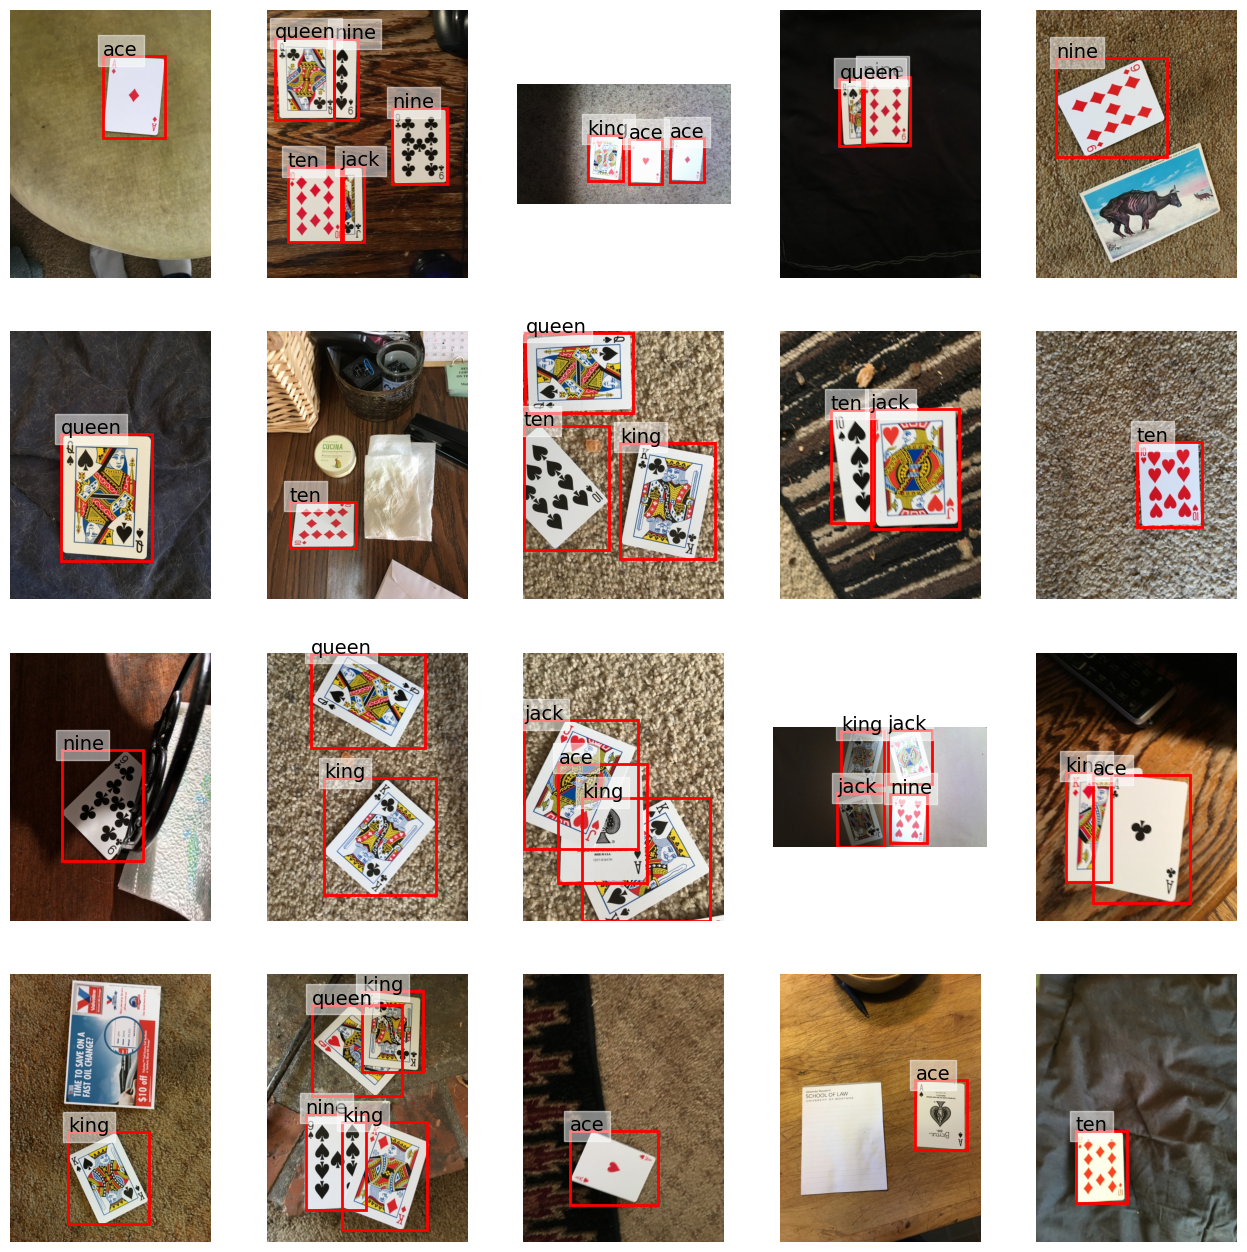

In [ ]:
files = os.listdir("images/train")

fig, axes = plt.subplots(4, 5, figsize=(16, 16))

# Итератор по изображениям
i = 0
# Итератор по файлам
j = 0
while i < 20:

    file = files[j]
    j += 1

    # Выбираем только картинки
    if file[-4:].lower() != ".jpg":
        continue
    img = Image.open(os.path.join("images/train", file))

    # Получаем лейблы и боксы, соотв. картинке
    labels, boxes = get_file_labels_boxes(data, file)

    # Визуализируем
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    plot_boxes(boxes, labels, classes, ax)
    ax.axis("off")

    i += 1

Для модели SSD300 нужны на вход картинки размера 300 x 300. Причем здесь нам не помогут разные трансформации из `torchvision.transforms`, так как нам нужно изменять еще и боксы. К нам в помощь приходит библиотека [Albumentations](https://albumentations.ai/docs/). Подробнее посмотреть как работать с библиотекой в случае детекции можно [тут](https://albumentations.ai/docs/examples/example_bboxes/).

Для того, чтобы обрезать картинки до квадрата так, чтобы карты точно там присутствовали, а потом ресайзнуть до размера 300 x 300, можно использовать следующую функцию. Можете также поэкспериментировать с Albumentations и сделать что-то более интересное.



In [ ]:
def spec_crop(image, boxes):
    """
    Функция, которая обрезает изображения до квадрата так,
    чтобы все боксы по возможности остались внутри квадрата.
    Полученные картинки приводятся к размеру 300x300.
    """

    # Вычисляем границы всех боксов вместе
    x_min = boxes[:, 0].min()
    y_min = boxes[:, 1].min()
    x_max = boxes[:, 2].max()
    y_max = boxes[:, 3].max()

    # Ширина и высота изображения
    h, w = image.size
    # Размер квадрата, до которого мы обрежем изображение
    size = min(h, w)
    half_size = size // 2

    # x-координата центра прямоугольника, ограничивающего все боксы
    x_ctr = (x_max - x_min) // 2 + x_min
    # По ней мы вычисляем x_min и x-max -- координаты квадрата,
    # который мы вырежем из исходного изображения,
    # чтобы получить квадратное изображение.
    if x_ctr < half_size:
        x_min = 0
        x_max = size - 1
    elif x_ctr + half_size >= h:
        x_max = h - 1
        x_min = x_max - size + 1
    else:
        x_min = x_ctr - half_size
        x_max = int(x_min + size) - 1

    # y-координата центра прямоугольника, ограничивающего все боксы
    y_ctr = (y_max - y_min) // 2 + y_min
    # По ней мы вычисляем y_min и y-max -- координаты квадрата,
    # который мы вырежем из исходного изображения,
    # чтобы получить квадратное изображение.
    if y_ctr < half_size:
        y_min = 0
        y_max = size - 1
    elif y_ctr + half_size >= w:
        y_max = w - 1
        y_min = y_max - size + 1
    else:
        y_min = y_ctr - half_size
        y_max = int(y_min + size) - 1

    # Приводим все координаты к int
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

    # Обрезаем изображение до квадрата и изменяем размер, полученного изображения
    transform = A.Compose([
        A.Crop(x_min, y_min, x_max, y_max),
        A.Resize(300, 300),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )
    transformed = transform(image=np.array(image), bboxes=boxes, labels=labels)
    image, boxes = transformed["image"], transformed["bboxes"]

    return image, boxes

Допустим, мы ограничились выше функцией `spec_crop`. Положим все обрезанные картинки в новую папку cropped_images.



In [ ]:
def change_file_boxes(data, file, boxes):
    """Функция, которая изменяет координаты боксов."""
    data.loc[data["filename"] == file, ["xmin", "ymin", "xmax", "ymax"]] = boxes


dir = "images"
res_dir = "cropped_images"
os.makedirs(res_dir, exist_ok=True)

for part in ["train", "test"]:
    # Создаем папку, если ее нет
    os.makedirs(os.path.join(res_dir, part), exist_ok=True)

    # Названия файлов с картинками и таблица с разметкой
    files = os.listdir(os.path.join(dir, part))
    data = pd.read_csv(os.path.join(dir, f"{part}_labels.csv"))
    data[["xmin", "ymin", "xmax", "ymax"]] = data[["xmin", "ymin", "xmax", "ymax"]].astype(float)

    for file in files:

        # Выбираем только картинки
        if file[-4:].lower() != ".jpg":
            continue
        image = Image.open(os.path.join(dir, part, file))

        # Получаем лейблы и координаты боксов
        labels, boxes = get_file_labels_boxes(data, file)

        # Обрезаем картинку
        image, boxes = spec_crop(image, boxes)

        # Сохраняем результат обрезки
        plt.imsave(os.path.join(res_dir, part, file), image)
        change_file_boxes(data, file, boxes)

    data.to_csv(os.path.join(res_dir, f"{part}_labels.csv"))

Предлагаем вам класс датасета, который будет хранить все картинки, боксы и лейблы в памяти. К счастью, их немного, зато такой подход будет быстрее работать. В данном случае скорость критична, в виду долгой работы сети в целом.

In [ ]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


class PlayingCardsDataset(Dataset):
    def __init__(self, images_path, data_path, input_size=(160, 240)):
        """
        Класс-датасет для задачи детекции игральных карт.
        """

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # Решайте сами, когда и зачем вам нужан нормализация
            transforms.Normalize(mean=MEAN, std=STD)])

        images, boxes, labels = self._read_images_boxes_labels(images_path, data_path)
        self.images = images
        self.boxes = boxes
        self.labels = labels


    def _read_images_boxes_labels(self, images_path, data_path):
        """
        Загружаем все изображения, а также соотвествующие им боксы и лейблы.
        """
        data = pd.read_csv(data_path)

        images = []
        boxes = []
        labels = []

        for file in os.listdir(images_path):
            image =  self.transform(Image.open(os.path.join(images_path, file)))
            labels_, boxes_ = get_file_labels_boxes(data, file)
            images.append(image)
            labels.append(torch.tensor(labels_))
            # Все координаты боксов делим на 300,
            # потому что в SSD используются относительные координаты.
            boxes.append(torch.tensor(boxes_) / 300)

        return images, boxes, labels

    def __len__(self,):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.boxes[idx], self.labels[idx]

Но есть одна загвоздка, просто так такой датасет в даталоадер не положишь, потому что он будет пытаться стекать лейблы и боксы. Однако для каждой картинки у нас разное число объектов, поэтому стекать не получится. Для этого нужно определить collate функцию, которая будет определять, как даталоадеру объединять данные в батч.

In [ ]:
def collate_fn(batch):
    """
    Эта функция поясняет как комбинировать данные в батч.
    Для этого мы будем использовать списки.
    Аргумент:
      batch: итерируемый объект из __getitem__()
    Возвращает:
      тензор картинок
    """

    images = []
    boxes = []
    labels = []

    for b in batch:
        images.append(b[0])
        boxes.append(b[1])
        labels.append(b[2])

    images = torch.stack(images)

    return images, boxes, labels

Таким образом мы можем получить даталоадер для обучающих данных.

In [ ]:
batch_size = 16
train_dataset = PlayingCardsDataset(
    images_path="cropped_images/train",
    data_path="cropped_images/train_labels.csv"
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=collate_fn)

Для тестовых данным нам хватит датасета.

In [ ]:
test_dataset = PlayingCardsDataset(
    images_path="cropped_images/test",
    data_path="cropped_images/test_labels.csv"
)

#### 2. Обучение SSD300 (50 баллов)
- Обучите SSD300 на датасете с игральными картами.
- Визуализируйте график лосса при обучении.

Для того, чтобы не тратить много времени, рассмотрите код функций обучения из `utils.py`. Некоторые из них можно поменять для удобства использования.

In [ ]:
# Клонируем репозиторий
! git clone https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection.git
# Копируем все из папки a-PyTorch-Tutorial-to-Object-Detection в текущую папку
! cp a-PyTorch-Tutorial-to-Object-Detection/* . -R -n -v
# Удаляем ненужные папки
! rm -r "a-PyTorch-Tutorial-to-Object-Detection"
! rm -r img


In [ ]:
from model import *

/content/utils.py:570: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if d.__name__ is 'adjust_hue':


In [ ]:
my_model = SSD300(n_classes=n_classes).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 179MB/s]



Loaded base model.



In [ ]:
criterion = MultiBoxLoss(my_model.priors_cxcy).to(device)
optimizer = torch.optim.SGD(my_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
# Гиперпараметры
epochs = 10
train_losses = []

# Обучение
for epoch in range(epochs):
    my_model.train()
    epoch_loss = 0

    for images, boxes, labels in train_dataloader:
        images = images.to(device)
        targets = [{"boxes": b.to(device), "labels": l.to(device)} for b, l in zip(boxes, labels)]

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        predicted_locs, predicted_scores = my_model(images)

        # Рассчитываем лосс
        loss = criterion(predicted_locs, predicted_scores, [t["boxes"].cuda() for t in targets], [t["labels"].cuda() for t in targets])

        # Обратный проход и обновление весов
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Средний лосс за эпоху
    avg_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 8.6707
Epoch [2/10], Loss: 8.4869
Epoch [3/10], Loss: 7.7895
Epoch [4/10], Loss: 5.7894
Epoch [5/10], Loss: 4.5823
Epoch [6/10], Loss: 3.9365
Epoch [7/10], Loss: 3.4083
Epoch [8/10], Loss: 3.0946
Epoch [9/10], Loss: 2.8304
Epoch [10/10], Loss: 2.5601


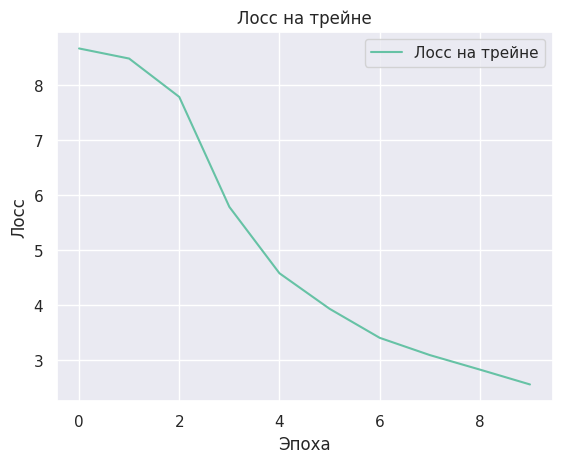

In [ ]:
# Визуализация графика лосса
plt.plot(train_losses, label="Лосс на трейне")
plt.xlabel("Эпоха")
plt.ylabel("Лосс")
plt.title("Лосс на трейне")
plt.legend()
plt.show()

#### 3. Инференс и визуализация. (45 баллов)
- Визуализируйте результаты детекции на тестовых данных. Не забудьте, что координаты боксов на выходе будут от 0 до 1. Их нужно умножить на 300.

In [ ]:
import torchvision.transforms.functional as F

def plot_predictions(dataset, model, classes, n_images=5, threshold=0.5):
    """
    Визуализация предсказаний модели на тестовых данных.

    Аргументы:
    - dataset: тестовый датасет
    - model: обученная модель SSD300
    - classes: список меток классов
    - n_images: количество изображений для отображения
    - threshold: минимальный порог уверенности предсказаний
    """
    model.eval()  # Переключение модели в режим оценки
    device = next(model.parameters()).device  # Устройство модели

    # Выбор нескольких случайных изображений
    indices = torch.randperm(len(dataset))[:n_images]

    for idx in indices:
        # Извлекаем изображение и истинные значения
        image, true_boxes, true_labels = dataset[idx]
        image = image.to(device).unsqueeze(0)  # Добавляем размер батча
        true_boxes = true_boxes * 300  # Масштабируем истинные боксы

        # Предсказания модели
        with torch.no_grad():
            predicted_locs, predicted_scores = model(image)
            detections = model.detect_objects(predicted_locs, predicted_scores,
                                              min_score=threshold, max_overlap=0.45, top_k=200)

        # Извлекаем предсказания
        predicted_boxes = detections[0][0] * 300  # Масштабируем боксы
        predicted_labels = detections[1][0]
        predicted_scores = detections[2][0]

        # Визуализация
        plt.figure(figsize=(8, 8))
        ax = plt.gca()
        image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Преобразуем в numpy
        true_boxes = true_boxes.cpu().numpy()
        predicted_boxes = predicted_boxes.cpu().numpy()

        image_np = image_np * torch.tensor([0.229, 0.224, 0.225]).cpu().numpy() + torch.tensor([0.485, 0.456, 0.406]).cpu().numpy()  # Денормализация
        image_np = image_np.clip(0, 1)  # Ограничение значений от 0 до 1
        plt.imshow(image_np)

        # Истинные боксы
        for box, label in zip(true_boxes, true_labels):
            x_min, y_min, x_max, y_max = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                  fill=False, color='green', linewidth=2)
            ax.add_patch(rect)
            plt.text(x_min, y_min, classes[label], color='green', fontsize=12)

        # Предсказанные боксы
        for box, label, score in zip(predicted_boxes, predicted_labels, predicted_scores):
            x_min, y_min, x_max, y_max = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                  fill=False, color='red', linewidth=2)
            ax.add_patch(rect)
            plt.text(x_min, y_min, f"{classes[label]}: {score:.2f}", color='red', fontsize=12)

        plt.axis('off')
        plt.show()


/content/model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  image_scores.append(class_scores[1 - suppress])


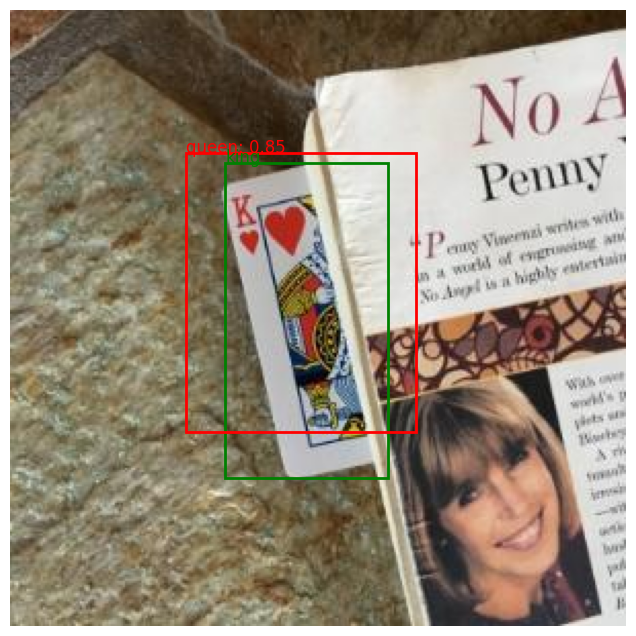

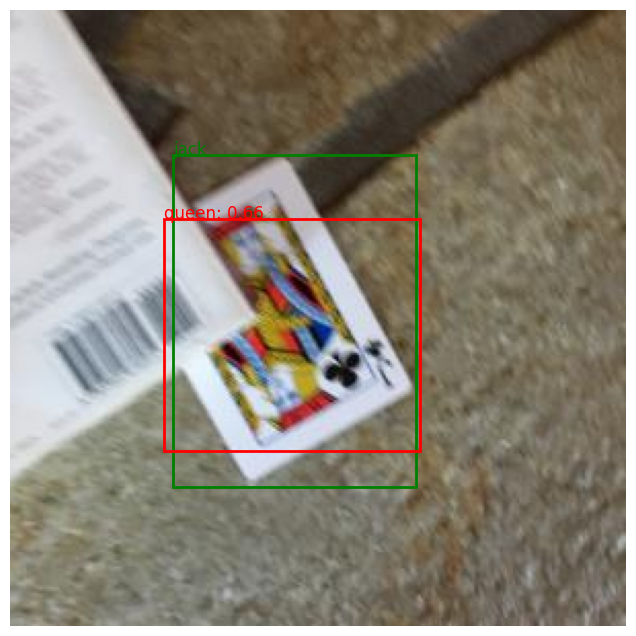

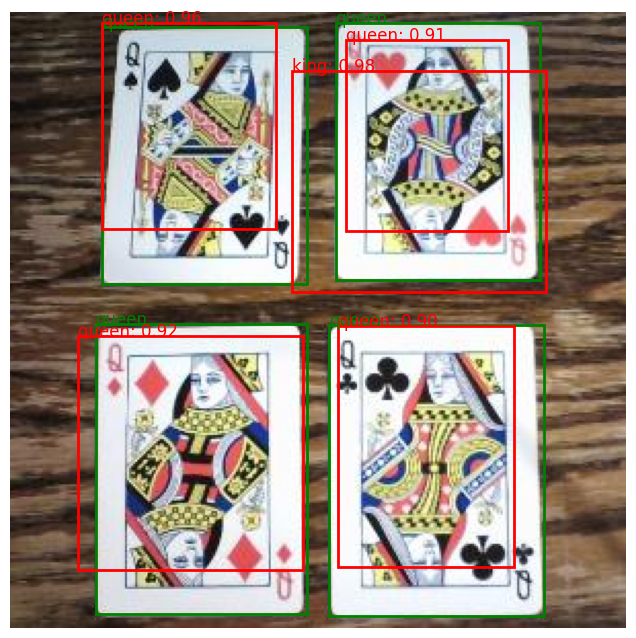

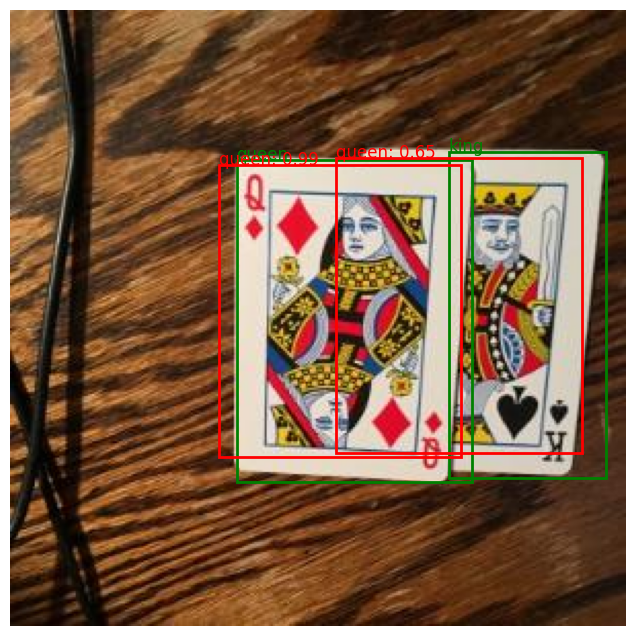

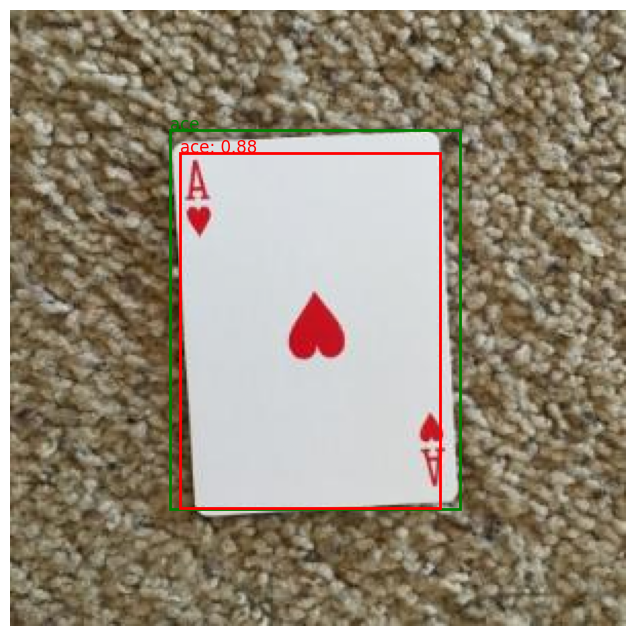

In [ ]:
plot_predictions(test_dataset, my_model, classes)

- Посчитайте mAP, пример см. в семинаре.

In [175]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def get_mAP(dataset, model, min_score=0.1, max_overlap=0.5, top_k=100):
    model.eval()
    device = next(model.parameters()).device

    metric = MeanAveragePrecision(iou_thresholds=[0.5, 0.75], max_detection_thresholds=[top_k, 2 * top_k, 3 * top_k], iou_type="bbox")

    for idx in range(len(dataset)):
        image, true_boxes, true_labels = dataset[idx]
        image = image.to(device).unsqueeze(0)
        true_boxes = true_boxes * 300
        valid_mask = true_labels != 0
        true_boxes = true_boxes[valid_mask]
        true_labels = true_labels[valid_mask]

        true_boxes = true_boxes.unsqueeze(0)
        true_labels = true_labels.unsqueeze(0)

        with torch.no_grad():
            predicted_locs, predicted_scores = model(image)
            detections = model.detect_objects(predicted_locs, predicted_scores,
                                              min_score=min_score, max_overlap=max_overlap, top_k=top_k)

        predicted_boxes = detections[0][0] * 300
        predicted_labels = detections[1][0]
        predicted_scores = detections[2][0]

        mask = predicted_labels != 0
        predicted_boxes = predicted_boxes[mask]
        predicted_labels = predicted_labels[mask]
        predicted_scores = predicted_scores[mask]

        preds = [
            {
                "boxes": predicted_boxes.cpu(),
                "scores": predicted_scores.cpu(),
                "labels": predicted_labels.cpu()
            }
        ]
        targets = [
            {
                "boxes": true_boxes.squeeze(0).cpu(),
                "labels": true_labels.squeeze(0).cpu()
            }
        ]

        metric.update(preds, targets)

    return metric.compute()



In [176]:
get_mAP(test_dataset, my_model)

{'map': tensor(0.3864),
 'map_50': tensor(0.5923),
 'map_75': tensor(0.1806),
 'map_small': tensor(-1.),
 'map_medium': tensor(0.2796),
 'map_large': tensor(0.4624),
 'mar_100': tensor(0.6157),
 'mar_200': tensor(0.6157),
 'mar_300': tensor(0.6157),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.4841),
 'mar_large': tensor(0.6744),
 'map_per_class': tensor(-1.),
 'mar_300_per_class': tensor(-1.),
 'classes': tensor([1, 2, 3, 4, 5, 6], dtype=torch.int32)}

- Посчитайте и визуализируйте матрицу ошибок (Confusion Matrix) на тестовых данных. Для подсчета матрицы используйте [реализацию CM из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), для визуализации &mdash; [heatmap из seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [166]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(dataset, model, iou_threshold=0.5, matrix_labels=list(range(8)),
                         top_k=50, min_score=0.5, max_overlap=0.5):

    """
    Подсчет матрицы ошибок для тестового датасета.

    Аргументы:
    - dataset: тестовый датасет.
    - model: обученная модель.
    - iou_threshold: порог IoU для определения соответствия предсказания истинному объекту.
    - matrix_labels: список всех возможных меток классов.
    - top_k: максимальное количество предсказаний.
    - min_score: минимальная вероятность для учёта предсказания.
    - max_overlap: порог IoU для подавления немаксимальных боксов.

    Возвращает:
    - cm: матрица ошибок.
    """

    device = next(model.parameters()).device
    model.eval()

    y_true = []
    y_pred = []

    for idx in range(len(dataset)):
        # Получаем изображение, истинные боксы и метки
        image, true_boxes, true_labels = dataset[idx]
        image = image.to(device).unsqueeze(0)
        true_boxes = true_boxes * 300
        valid_mask = true_labels != 0
        true_boxes = true_boxes[valid_mask]
        true_labels = true_labels[valid_mask].to(device)

        if true_boxes.numel() == 0 or true_labels.numel() == 0:
            continue

        # Предсказания модели
        with torch.no_grad():
            predicted_locs, predicted_scores = model(image)
            detections = model.detect_objects(predicted_locs, predicted_scores.to(device),
                                              min_score=min_score, max_overlap=max_overlap, top_k=top_k)

        predicted_boxes = (detections[0][0] * 300)
        predicted_labels = detections[1][0]
        predicted_scores = detections[2][0]

        # Исключаем предсказания класса "background"
        mask = predicted_labels != 0
        predicted_boxes = predicted_boxes[mask]
        predicted_labels = predicted_labels[mask]
        predicted_scores = predicted_scores[mask]

        predicted_boxes = predicted_boxes.to(device)
        true_boxes = true_boxes.to(device)

        # Обработка соответствия предсказаний истинным меткам по IoU
        if predicted_boxes.numel() > 0:
            overlaps = find_jaccard_overlap(predicted_boxes.to(device), true_boxes.to(device))  # (N_pred, N_true)
            max_overlap, indices = overlaps.max(dim=1)  # (N_pred)
            indices = indices.to(device)

            valid_mask = max_overlap > iou_threshold

            if valid_mask.sum() > 0:
                pred_labels = predicted_labels[valid_mask].tolist()

                # Применяем valid_mask к indices
                indices = indices[valid_mask]

                true_labels_matched = true_labels[indices].tolist()

                #pred_labels += [-1]*(len(true_labels_matched)-len(pred_labels))

                y_pred.extend(pred_labels)
                y_true.extend(true_labels_matched)

    # Вычисляем confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=matrix_labels)

    return cm


In [173]:
import seaborn as sns

def plot_confusion_matrix(
    dataset, model, display_labels,
    iou_threshold=0.5, matrix_labels=list(range(1, 8)),
    top_k=50, min_score=0.5, max_overlap=0.5
):
    """
    Визуализация confusion matrix для тестового набора данных.

    Аргументы:
    - dataset: тестовый датасет.
    - model: обученная модель.
    - display_labels: отображаемые лейблы классов.
    - iou_threshold: порог IoU для определения соответствия предсказания истинному объекту.
    - top_k: максимальное количество предсказаний.
    - min_score: минимальная вероятность для учёта предсказания.
    - max_overlap: порог IoU для подавления немаксимальных боксов.
    """
    # Получаем матрицу ошибок
    cm = get_confusion_matrix(dataset, model, iou_threshold, matrix_labels, top_k=200, min_score=0.1, max_overlap=0.1)

    # Визуализируем с помощью heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=display_labels, yticklabels=display_labels, cmap="Blues")
    plt.xlabel("Предсказанные метки")
    plt.ylabel("Истинные метки")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
plot_confusion_matrix(test_dataset, my_model, display_labels=classes[1:])

**Вывод:**

...

#### 4. Маленькие карты

Уменьшим карты на картинках. Для этого будем случайно собирать 4 изображения из датасета и соединять их в коллаж, тем самым получая изображение с более мелкими объектами. Можно использовать и другие способы уменьшения, но данный способ, на взгляд автора, дает более реалистичные изображения и не очень трудозатратный.

In [ ]:
def get_smaller_images(images, old_boxes):
    """
    Уменьшает изображения и соотвествующие ему боксы.

    :param images -- изображения, их должно быть 4
    :param boxes -- боксы, соотвествующие каждому изображению
    """
    image = torch.zeros((3, 300, 300))
    boxes = []

    transform = transforms.Resize((150, 150))
    for i, j in zip([0, 0, 1, 1], [0, 1, 0, 1]):
        image[:, 150 * i: 150 * (i + 1), 150 * j: 150 * (j + 1)] = transform(images[i * 2 + j])
        for box in old_boxes[i * 2 + j]:
            x_min, y_min, x_max, y_max = box * 0.5
            x_min += j * 0.5
            x_max += j * 0.5
            y_min += i * 0.5
            y_max += i * 0.5
            boxes.append([x_min, y_min, x_max, y_max])

    return image, boxes

Создадим целую папку с изображениями, уменьшенными выше описанным способом.

In [ ]:
# Создаем папку, если ее нет
os.makedirs(res_dir, exist_ok=True)

totensor = transforms.ToTensor()

for part in ["train", "test"]:
    # Создаем папку, если ее нет
    os.makedirs(os.path.join(res_dir, part), exist_ok=True)

    # Названия файлов с картинками и таблица с разметкой
    files = os.listdir(os.path.join(dir, part))
    data = pd.read_csv(os.path.join(dir, f"{part}_labels.csv"))
    new_data = pd.DataFrame(columns=['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
    print(f"Количество изображений в исходных {part} данных: {len(files)}")

    if part == "train":
        num_images = 300
    else:
        num_images = 70

    for i in range(300):

        # Собираем 4 изображения
        n = 0
        images, all_boxes, all_labels = [], [], []
        while n < 4:
            file = np.random.choice(files)
            if file[-4:].lower() != ".jpg":
                continue

            image = totensor(Image.open(os.path.join(dir, part, file)))
            labels, boxes = get_file_labels_boxes(data, file)
            images.append(image)
            # Переводим боксы в относительную шкалу
            boxes /= 300
            all_boxes.append(boxes)
            all_labels.extend(labels)
            n += 1

        # Собираем одну картинку из несокльких маленьких
        image, boxes = get_smaller_images(images, all_boxes)
        boxes = [[float(c) * 300 for c in box] for box in boxes]

        # Сохраняем результат
        filename = f'image{i}.jpg'
        plt.imsave(os.path.join(res_dir, part, filename), image.permute(1, 2, 0).numpy())

        for box, label in zip(boxes, all_labels):
            new_data = new_data.append({'filename': filename, 'class': classes[label],
                            'xmin': box[0], 'ymin': box[1], 'xmax': box[2], 'ymax': box[3],},
                            ignore_index=True)

    new_data.to_csv(os.path.join(res_dir, f"{part}_labels.csv"))

Посмотрим, что получилось.

In [ ]:
files = os.listdir("small_images/train")
data = pd.read_csv("small_images/train_labels.csv")

fig, axes = plt.subplots(4, 5, figsize=(20,20))

# Итератор по изображениям
i = 0
# Итератор по файлам
j = 0
while i < 20:

    file = files[j]
    j += 1

    # Выбираем только картинки
    if file[-4:].lower() != ".jpg":
        continue
    img = Image.open(os.path.join("small_images/train", file))

    # Получаем лейблы и боксы, соотв. картинке
    labels, boxes = get_file_labels_boxes(data, file)

    # Визуализируем
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    plot_boxes(boxes, labels, classes, ax)
    ax.axis("off")

    i += 1